### KDD 2022 Hands-on Tutorial on "Gradual AutoML using Lale"

# 9. Compatibility with scikit-learn

Lale, as a wrapper around scikit-learn, tries to simplify compatibility with scikit-learn.
For example, in many cases, a scikit-learn operator can be passed to Lale,
and a Lale operator can be used with scikit-learn.

This notebook presents some more information about converting scikit-learn code to lale,
and some important compatibility features.

The [New Operators](08_newops.ipynb) notebook contains information on how to create lale wrappers for custom
operators.

This notebook has the following sections:

- [9.1 Going from scikit-learn to Lale](#9.1-Going-from-scikit-learn-to-Lale)
- [9.2 Going from Lale to scikit-learn](#9.2-Going-from-Lale-to-scikit-learn)
- [9.3 scikit-learn conventions and Lale](#9.3-scikit-learn-conventions-and-Lale)

## 9.1 Going from scikit-learn to Lale

Given existing pipelines that uses scikit-learn, there are a number of ways that they can be converted into Lale pipelines.
As an example, assume the following code:

In [1]:
def example_sklearn():
    from sklearn.pipeline import make_pipeline

    from sklearn.preprocessing import MinMaxScaler
    from sklearn.decomposition import PCA
    from sklearn.ensemble import RandomForestClassifier

    return make_pipeline(MinMaxScaler(), PCA(), RandomForestClassifier())
example_sklearn()

Pipeline(steps=[('minmaxscaler', MinMaxScaler()), ('pca', PCA()),
                ('randomforestclassifier', RandomForestClassifier())])

### 9.1.1 Changing imports
Assuming that Lale provides wrappers for the operators being used, 
it is generally straightforward to change the `import` declarations
to use the Lale wrappers instead of the underlying impl.
For our example, this would look like:

In [2]:
def example_imports():
    from lale.operators import make_pipeline

    from lale.lib.sklearn import MinMaxScaler
    from lale.lib.sklearn import PCA
    from lale.lib.sklearn import RandomForestClassifier

    return make_pipeline(MinMaxScaler(), PCA(), RandomForestClassifier())
example_imports()

Of course, we can also change the code to be more idiomatic by using Lale combinators.

In [3]:
def example_idiomatic():

    from lale.lib.sklearn import MinMaxScaler
    from lale.lib.sklearn import PCA
    from lale.lib.sklearn import RandomForestClassifier

    return MinMaxScaler() >> PCA() >> RandomForestClassifier()
example_idiomatic()

### 9.1.2 `wrap_imported_operators`
Alternatively, instead of changing the imports, you can call 
`lale.wrap_imported_operators` to change the imports for you,
as follows:

In [4]:
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

from lale import wrap_imported_operators
wrap_imported_operators()

example_wrapped = make_pipeline(MinMaxScaler(), PCA(), RandomForestClassifier())
# notice that this is now a lale TrainableOperator
type(example_wrapped.steps[0][1])

lale.operators.TrainableIndividualOp

This functions uses Python hackery to modify the symbol table
so that the imported names actually refer to their Lale wrappers.

### 9.1.3 `import_from_sklearn_pipeline`
The previous two options work well for migrating source code.  However, there are many times
were the code is provided (at runtime) with an existing scikit-learn pipeline.
This pipeline can be converted into a Lale pipeline (and its operators replace with the appropriate Lale wrappers, when possible), by calling `import_from_sklearn_pipeline` as follows:

original: Pipeline(steps=[('minmaxscaler', MinMaxScaler()), ('pca', PCA()),
                ('randomforestclassifier', RandomForestClassifier())])
imported: <lale.operators.TrainedPipeline object at 0x137267df0>


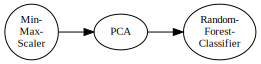

In [5]:
from lale.helpers import import_from_sklearn_pipeline

sk_pipe = example_sklearn()
print(f"original: {sk_pipe}")
imported_pipe = import_from_sklearn_pipeline(sk_pipe)
print(f"imported: {imported_pipe}")
imported_pipe.visualize()

## 9.2 Going from Lale to scikit-learn

Sometimes there is a need to get the underlying operators out

### 9.2.1 Individual Operators
To get the operator underlying a Lale wrapper, use its `impl` property as follows.  For example,

In [6]:
lale_pipeline = example_idiomatic()
lale_op = lale_pipeline.steps[0][1]
print(f"The first operator is: {lale_op}")
op_impl = lale_op.impl
print(f"The type of its underlying impl is: {type(op_impl)}")

The first operator is: MinMaxScaler
The type of its underlying impl is: <class 'sklearn.preprocessing._data.MinMaxScaler'>


### 9.2.2 A pipeline
The `export_to_sklearn_pipeline` method will try to convert a pipeline into a scikit-learn pipeline, recursively converting its constituent operators into their unwrapped, base implementation.
Note that this is not generally possible, as Lale pipelines are strictly more expressive than scikit-learn pipelines.
As an example,

In [7]:
exported_pipeline = lale_pipeline.export_to_sklearn_pipeline()
print(exported_pipeline)

/usr/local/var/pyenv/versions/3.8.9/envs/lale389new/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Pipeline(steps=[('minmaxscaler', MinMaxScaler()), ('pca', PCA()),
                ('randomforestclassifier', RandomForestClassifier())])


/usr/local/var/pyenv/versions/3.8.9/envs/lale389new/lib/python3.8/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


## 9.3 scikit-learn conventions and Lale

When possible, Lale supports various scikit-learn conventions.  
In particular, it supports cloning, parameter getting/setting, property forwarding, and operator type checking.
To present some examples, we first load a dataset and use a subset of it to train our lale pipeline:

In [8]:
import lale.datasets.openml
import pandas as pd
import numpy as np

(train_X, train_y), (test_X, test_y) = lale.datasets.openml.fetch(
    'credit-g', 'classification', preprocess=True)

trained_lale_pipeline = lale_pipeline.fit(np.array(train_X), np.array(train_y))

### 9.3.1 `clone`-ing
In scikit-learn, operators are cloned using the [`sklearn.base.clone`](https://scikit-learn.org/stable/modules/generated/sklearn.base.clone.html) method.  

Lale is carefully designed so that calling this `clone` method on a lale operator will work, behaving as it does for scikit-learn operators.  Note that as per scikit-learn conventions, calling `clone` on a `TrainedOperator` will return a `TrainableOperator`, since, by design, cloning does not preserve trained parameters.
As an example,

In [9]:
from sklearn.base import clone


print(f"cloning a trainable pipeline, type is: {clone(lale_pipeline)}")
print(f"cloning a trained pipeline, type is: {clone(trained_lale_pipeline)}")

cloning a trainable pipeline, type is: <lale.operators.TrainablePipeline object at 0x13bbacc70>
cloning a trained pipeline, type is: <lale.operators.TrainablePipeline object at 0x13bbacc10>


### 9.3.2 `get/set/with_params`
Like scikit-learn operators, Lale operators provide a `get_params` method to retrieve the hyper-parameters set for an operator/pipeline, and `set_params` to set those parameters.
Lale also provides `with_params`, a functional variant of `set_params` that creates a new operator with the modified hyper-parameters instead of mutating the given operator.

When any of these methods are used on a pipeline, the scikit learn convention of prepending `operatorname__` to the hyerparameter is used.  Additional encodings are used for other pipeline features, such as choice, that scikit-learn does not support.

In [10]:
lale_pipeline.get_params()

{'steps': [MinMaxScaler(), PCA(), RandomForestClassifier()],
 'MinMaxScaler__clip': False,
 'MinMaxScaler__copy': True,
 'MinMaxScaler__feature_range': (0, 1),
 'PCA__copy': True,
 'PCA__iterated_power': 'auto',
 'PCA__n_components': None,
 'PCA__random_state': None,
 'PCA__svd_solver': 'auto',
 'PCA__tol': 0.0,
 'PCA__whiten': False,
 'RandomForestClassifier__bootstrap': True,
 'RandomForestClassifier__ccp_alpha': 0.0,
 'RandomForestClassifier__class_weight': None,
 'RandomForestClassifier__criterion': 'gini',
 'RandomForestClassifier__max_depth': None,
 'RandomForestClassifier__max_features': 'auto',
 'RandomForestClassifier__max_leaf_nodes': None,
 'RandomForestClassifier__max_samples': None,
 'RandomForestClassifier__min_impurity_decrease': 0.0,
 'RandomForestClassifier__min_samples_leaf': 1,
 'RandomForestClassifier__min_samples_split': 2,
 'RandomForestClassifier__min_weight_fraction_leaf': 0.0,
 'RandomForestClassifier__n_estimators': 100,
 'RandomForestClassifier__n_jobs': None

###  9.3.3 Attribute forwarding
Many operator implementations provide additional properties or methods that provide additional information, especially after the operator has been trained.
If needed, these can be accessed using the operator `.impl` property, as mentioned above.
However, this is generally not needed, as Lale supports transparent forwarding of properties/fields/methods.

As long as there is no name conflict (such as a property called `get_params`), unknown attributes are transparently forwarded to the underlying implementation for resolution.  As mentioned in the [New Operators](08_newops.ipynb) notebook, this can be restricted by the operator for increased control.

In addition to convenience, this enables Lale operators to replace unwrapped scikit-learn operators with minimal changes needed to the code.

As an example, the MinMaxScalar implementation sets the `n_features_in_` property after `fit` is called:

In [11]:
trained_minmax = trained_lale_pipeline.steps[0][1]
assert (trained_minmax.n_features_in_ == trained_minmax.impl.n_features_in_)

trained_minmax.n_features_in_

61

###  9.3.4 isinstance checking
It is sometimes important to check the type of an operator.  For example, code may wish to have a special case for
`MinMaxScaler`, and would like to check if an operator is that type.
In Lale, this would appear to be challenging, due to our use of wrapper classes.  Nonetheless, due to judicious use of Python's features, it is possible to use a simple `isinstance` check as follows:

In [12]:
from lale.lib.sklearn import MinMaxScaler
    
isinstance(trained_minmax, MinMaxScaler)

True